In [7]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from pandas import Timestamp
from sklearn.model_selection import train_test_split
import warnings
import requests
from bs4 import BeautifulSoup


warnings.filterwarnings("ignore")

In [8]:
excel_file = pd.ExcelFile("queues_2023_clean_data.xlsx")
interconnection_data = excel_file.parse("data")

In [9]:
interconnection_data.drop(["q_year", "prop_year"], axis=1, inplace=True)

In [10]:
date_columns = ["q_date", "ia_date", "wd_date", "on_date", "prop_date"]
for col in date_columns:
    interconnection_data[col] = pd.to_datetime(
        interconnection_data[col], errors="coerce"
    )


interconnection_data

,q_id,q_status,q_date,ia_date,wd_date,on_date,entity,project_name,developer,utility,...,prop_date,IA_status_raw,IA_status_clean,type_clean,type1,type2,type3,mw1,mw2,mw3
0,GIA-50,withdrawn,2014-12-18,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2016-12-01,Withdrawn,Withdrawn,Wind,Wind,NaN,NaN,300.0,NaN,NaN
1,GIA-105,active,2022-07-21,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2025-10-01,FS,Facilities Study,Gas,Gas,NaN,NaN,460.0,NaN,NaN
2,GIA-83,active,2019-06-19,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2025-07-01,GIA,IA Executed,Wind,Wind,NaN,NaN,1018.0,NaN,NaN
3,GIA-113,active,2023-01-13,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2026-12-01,SIS,System Impact Study,Wind,Wind,NaN,NaN,500.0,NaN,NaN
4,GIA-73,withdrawn,2018-11-19,NaT,NaT,NaT,AEC,NaN,NaN,NaN,...,2021-10-01,Withdrawn,Withdrawn,Solar,Solar,NaN,NaN,300.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32508,2023-G2,active,2023-03-01,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,"FEC,SISE",System Impact Study,Solar+Battery,Solar,Battery,NaN,800.0,NaN,NaN
32509,2015-G1,withdrawn,2015-01-26,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,"FENR, SISC, FSE, W",Facility Study,Solar,Solar,NaN,NaN,26.0,NaN,NaN
32510,2023-G3,withdrawn,2023-03-24,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,Scoping,Not Started,Solar+Battery,Solar,Battery,NaN,100.0,NaN,NaN
32511,2019-G1,active,2019-08-08,NaT,NaT,NaT,WAPA-SN,NaN,NaN,WAPA-SN,...,NaT,"FEC, SISC, FSE",Facility Study,Solar+Battery,Solar,Battery,NaN,300.0,NaN,NaN


In [11]:
def categorical_change(data, column):
    """Changes a column into categorical variables"""
    i = 0
    seen = {}
    categorical = []
    for _, row in data.iterrows():
        item = row[column]
        if item not in seen:
            seen[item] = i
            i += 1
        categorical.append(seen[item])
    data[column] = categorical


def select_iso(data, *isos):
    "Extracts data from select isos"
    result = []
    for iso in isos:
        result.append(data[data["entity"] == iso])
    result = tuple(result)
    return result


def sort_iso(*isos):
    """Sort ISO by the date they entred the queue"""
    result = []
    for iso in isos:
        sorted_iso = iso.sort_values(by="q_date", ascending=True)
        result.append(sorted_iso)
    result = tuple(result)
    return result


def calculate_difference(df, unit="years"):
    """For projects that have been deployed, calculates
    the time difference between the start date and end date."""

    time_difference = []

    for index, row in df.iterrows():
        delta_days = (row["on_date"] - row["q_date"]).days

        if unit == "years":
            time_difference.append(delta_days / 365.25)
        elif unit == "months":
            time_difference.append(delta_days / 30.44)
        elif unit == "days":
            time_difference.append(float(delta_days))
    return time_difference


def base_features(iso):
    iso["queue"] = queue_length(iso)
    categorical_columns = ["type1", "type2", "type3"]
    for col in categorical_columns:
        categorical_change(iso, col)
    X = np.nan_to_num(
        iso[["type1", "type2", "type3", "mw1", "mw2", "mw3", "queue"]]
    )
    return X

def data_split(iso,queue_func=None, time_unit="days", randomness=True):
    iso = iso[iso["on_date"].notna()]  # only select projects that have been deployed
    iso["time_difference"] = calculate_difference(iso, time_unit)
    X = base_features(iso)
    extra_features = pd.DataFrame()
    if queue_func:
        extra_features = queue_func(iso).to_numpy()
        X = np.concatenate((X,extra_features),axis=1)
    y = np.nan_to_num(iso["time_difference"].to_numpy())
    if randomness:
        return train_test_split(X, y, test_size=0.3, random_state=42)
    else:
        return train_test_split(X, y, test_size=0.3)


def queue_length(iso, initial_queue=0):
    """Calculates the queue length over time based on project additions, completions, and withdrawals."""
    queues = np.zeros(iso.shape[0])
    queues[0] = initial_queue

    completion_dates = sorted(iso[iso["on_date"].notna()]["on_date"].tolist())
    withdraw_dates = sorted(iso[iso["wd_date"].notna()]["wd_date"].tolist())

    print(f"Total Completed Projects: {len(completion_dates)}")
    print(f"Total Withdrawn Projects: {len(withdraw_dates)}")

    first_completion_date = (
        completion_dates[0] if completion_dates else Timestamp("2099-12-12")
    )
    first_withdraw_date = (
        withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
    )

    for i, (_, row) in enumerate(iso.iterrows()):
        current_time = row["q_date"]

        if i > 0:
            queues[i] = queues[i - 1]

        queues[i] += 1

        while (
            first_completion_date <= current_time or first_withdraw_date <= current_time
        ):
            if first_completion_date <= first_withdraw_date:
                queues[i] -= 1
                completion_dates.pop(0)
                first_completion_date = (
                    completion_dates[0] if completion_dates else Timestamp("2099-12-12")
                )
            else:
                queues[i] -= 1
                withdraw_dates.pop(0)
                first_withdraw_date = (
                    withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
                )

        queues[i] = max(queues[i], 0)

    return queues


caiso, ercot, pjm, iso_ne = select_iso(
    interconnection_data, "CAISO", "ERCOT", "PJM", "ISO-NE"
)
sorted_caiso, sorted_ercot, sorted_pjm, sorted_iso_ne = sort_iso(
    caiso, ercot, pjm, iso_ne
)
sorted_pjm.head()

,q_id,q_status,q_date,ia_date,wd_date,on_date,entity,project_name,developer,utility,...,prop_date,IA_status_raw,IA_status_clean,type_clean,type1,type2,type3,mw1,mw2,mw3
19359,A05,operational,1997-04-01,2000-12-15,NaT,NaT,PJM,Bergen,NaN,PSEG,...,NaT,IA Executed,IA Executed,Gas,Gas,NaN,NaN,500.0,NaN,NaN
19243,A04,operational,1997-04-01,NaT,NaT,NaT,PJM,"Linden 1, 2 & 3",NaN,PPL,...,NaT,IA Executed,IA Executed,Gas,Gas,NaN,NaN,750.0,NaN,NaN
20245,A01,operational,1997-04-01,NaT,NaT,NaT,PJM,Ironwood,NaN,ME,...,NaT,IA Executed,IA Executed,Gas,Gas,NaN,NaN,720.0,NaN,NaN
18651,A06,withdrawn,1997-04-01,NaT,2000-08-28,NaT,PJM,NaN,NaN,PSEG,...,NaT,System Impact Study,System Impact Study,Gas,Gas,NaN,NaN,750.0,NaN,NaN
20651,A03,operational,1997-04-01,2000-04-24,NaT,NaT,PJM,Linden 5 & 6,NaN,PSEG,...,NaT,IA Executed,IA Executed,Gas,Gas,NaN,NaN,120.0,NaN,NaN


In [12]:
# def find_date(iso,q_id):
#     q_id=q_id.lower()
#     url = f"https://www.interconnection.fyi/project/{iso}-{q_id}"  # Replace with your actual URL
#     response = requests.get(url)

#     # Parse the HTML
#     soup = BeautifulSoup(response.content, "html.parser")

#     # Navigate to the desired element
#     # This example goes into the table, gets the 14th row, and the 2nd column
#     table = soup.find("table")
#     rows = table.find_all("tr")
#     date_list = []
#     for target_row in rows:
#         cells = target_row.find_all("td")
#         if len(cells) >= 2:
#             date_str=(cells[1].get_text(strip=True))
#             try:
#                 date = datetime.strptime(date_str, "%B %d, %Y").date()
#                 date_list.append(date)
#             except Exception:
#                 continue

#     return max(date_list)

# def add_on_dates(iso,name):
#     count=0
#     for index, row in iso.iterrows():
#         count+=1
#         if count%50==0:
#             print(count, name)
#         status = row["q_status"]
#         if status == "operational":
#             if not pd.notna(row["on_date"]):
#                 try:
#                     date = find_date(name, row["q_id"])
#                     sorted_pjm.loc[index, "on_date"] = date
#                 except Exception:
#                     continue
#                 print(row["q_id"])
#                 break

# iso_list = {
#     "California": sorted_caiso,
#     "ERCOT": sorted_ercot,
#     "PJM": sorted_pjm,
#     "New England": sorted_iso_ne,
# }
# for name, iso in iso_list.items():
#     add_on_dates(iso,name)

In [13]:
count=0
for i, (_, row) in enumerate(sorted_pjm.iterrows()):
    if row["q_status"]=="operational":
        count+=1
print(count)


1163


In [14]:
renewable = {
    'Solar',
    'Wind',
    'Offshore Wind',
    'Hydro',
    'Biomass',
    'Landfill',
    'Biofuel',
}

non_renewable = {
    'Coal',
    'Gas',
    'Oil',
    'Nuclear',
    'Co-Gen',
    'Steam Turbine',
    'Fuel Cell',
}

storage = {
    'Battery',
    'Pumped Storage',
    'Other Storage',
}

uncategorized = {
    'Other',
    'Unknown',
    float('nan'),  # or `nan` if using NumPy
}

def exited_projects(iso):
    completed_projects = iso[iso["on_date"].notna() | iso["wd_date"].notna()]
    project_properties = completed_projects[["on_date","wd_date","type1","type2","type3","mw1","mw2","mw3"]]
    exit_dates = []
    for index, rows in completed_projects.iterrows():
        if pd.isna(rows["on_date"]):
            exit_dates.append(rows["wd_date"])
        else:
            exit_dates.append(rows["on_date"])
    project_properties["exit_date"]=exit_dates
    project_properties.drop(["on_date", "wd_date"], axis=1, inplace=True)
    project_properties = project_properties.fillna(0)
    project_properties = project_properties.sort_values(by = "exit_date")
    list_of_tuples = list(project_properties.itertuples(index=False, name=None))
    return list_of_tuples

def first_exit_projects(list_of_tuples):
    first_exit = list_of_tuples.pop(0)
    first_exit_date = first_exit[-1]
    first_exit_types = first_exit[:3]
    first_exit_capacities = first_exit[3:6]
    return first_exit_date, first_exit_types, first_exit_capacities

def renewable_split(data):
    """
    Converts the 'type1', 'type2', and 'type3' columns of the input DataFrame into
    categorical values:
        1 - Renewable
        2 - Non-renewable
        3 - Storage
        0 - Unknown
    """
    new_df = data.copy()
    for column in ["type1", "type2", "type3"]:
        new_df[column] = data[column].apply(
            lambda x: 1 if x in renewable else
                      2 if x in non_renewable else
                      3 if x in storage else 0
        )
    return new_df
def queue_by_category(iso):
    renewable_iso = renewable_split(iso) # this converts type1/2/3 into 1, 2, 3 (renewable, non-renewable, storage)

    # Initialize matrix: rows = each project over time, cols = [renewable, non-renewable, storage]
    X = np.zeros((len(renewable_iso), 3))

    # Get and sort exits
    list_of_tuples = exited_projects(renewable_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, _ = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types = pd.Timestamp("2099-12-31"), []

    for i, (_, row) in enumerate(renewable_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])

        # Inherit previous values
        if i > 0:
            X[i, :] = X[i - 1, :]

        # Add current project's types
        for t in types:
            if t == 1:
                X[i, 0] += 1  # renewable
            elif t == 2:
                X[i, 1] += 1  # non-renewable
            elif t == 3:
                X[i, 2] += 1  # storage

        # Subtract exited projects until the current date
        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for t in first_exit_types:
                if t == 1:
                    X[i, 0] -= 1
                elif t == 2:
                    X[i, 1] -= 1
                elif t == 3:
                    X[i, 2] -= 1
            if list_of_tuples:
                first_exit_date, first_exit_types, _ = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Optional: convert to DataFrame
    out_df = pd.DataFrame()
    out_df[["n_renewable", "n_non_renewable", "n_storage"]] =X
    return out_df

def queue_by_category_and_capacity(iso):
    renewable_iso = renewable_split(iso)  # ensures type1/2/3 are 1/2/3 (renewable, non-renewable, storage)

    # Initialize matrix: rows = each time step, cols = [count_ren, count_nonren, count_storage, mw_ren, mw_nonren, mw_storage]
    X = np.zeros((len(renewable_iso), 6))

    # Get and sort exits
    list_of_tuples = exited_projects(renewable_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types, first_exit_capacities = pd.Timestamp("2099-12-31"), [], []

    for i, (_, row) in enumerate(renewable_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])
        capacities = (row["mw1"], row["mw2"], row["mw3"])

        # Inherit previous values
        if i > 0:
            X[i, :] = X[i - 1, :]

        # Add counts and capacities
        for idx, t in enumerate(types):
            if t in [1, 2, 3]:  # only handle valid categories
                X[i, t - 1] += 1  # count type
                if not pd.isna(capacities[idx]):
                    X[i, t + 2] += capacities[idx]  # offset by 3 to store capacity


        # Subtract exited projects
        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for idx, t in enumerate(first_exit_types):
                if t in [1, 2, 3]:  # ensure valid types
                    X[i, t - 1] -= 1
                    X[i, t + 2] -= first_exit_capacities[idx]

            if list_of_tuples:
                first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Create output DataFrame
    # out_df = renewable_iso.copy()
    out_df = pd.DataFrame()
    out_df[[
        "n_renewable", "n_non_renewable", "n_storage",
        "mw_renewable", "mw_non_renewable", "mw_storage"
    ]] = X

    return out_df


Total Completed Projects: 137
Total Withdrawn Projects: 281


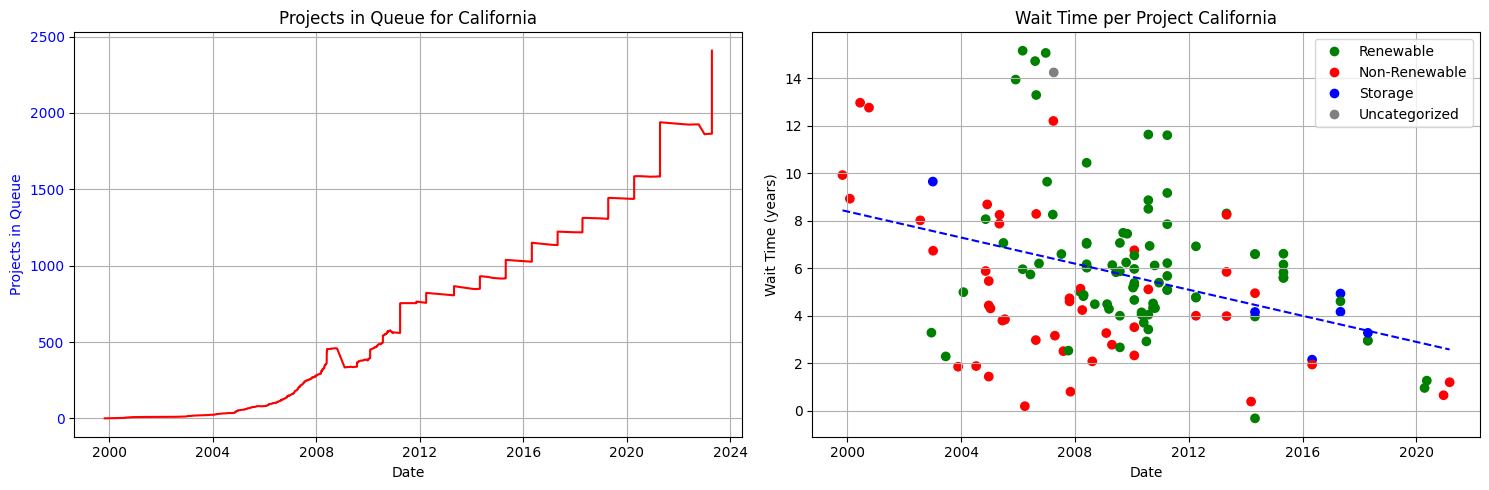

Total Completed Projects: 191
Total Withdrawn Projects: 45


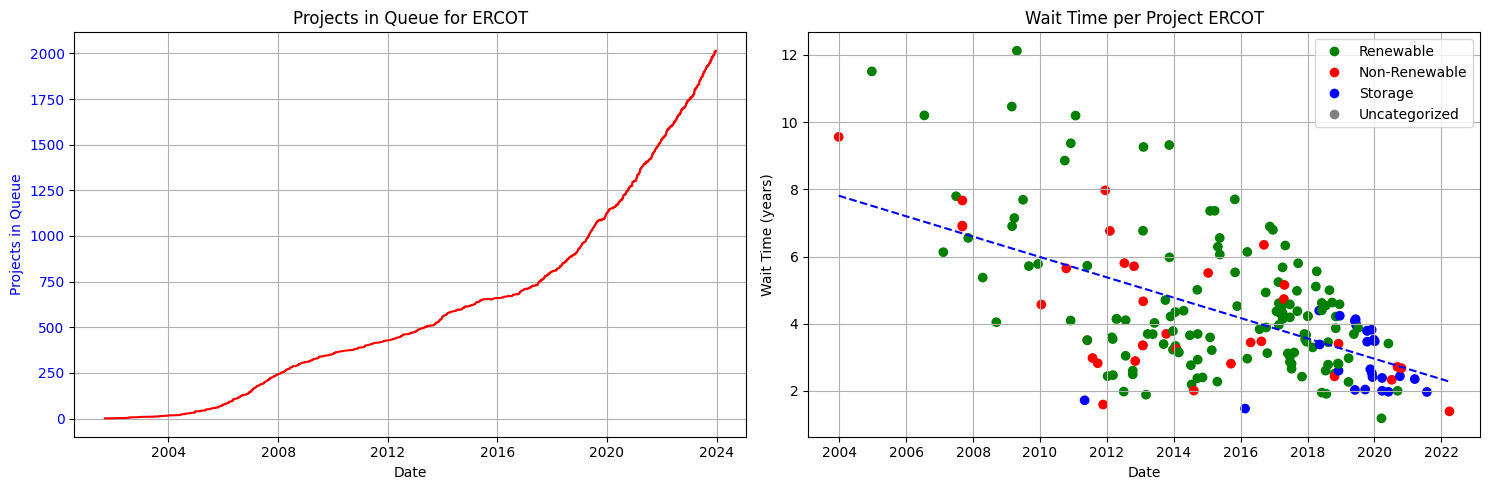

Total Completed Projects: 178
Total Withdrawn Projects: 92


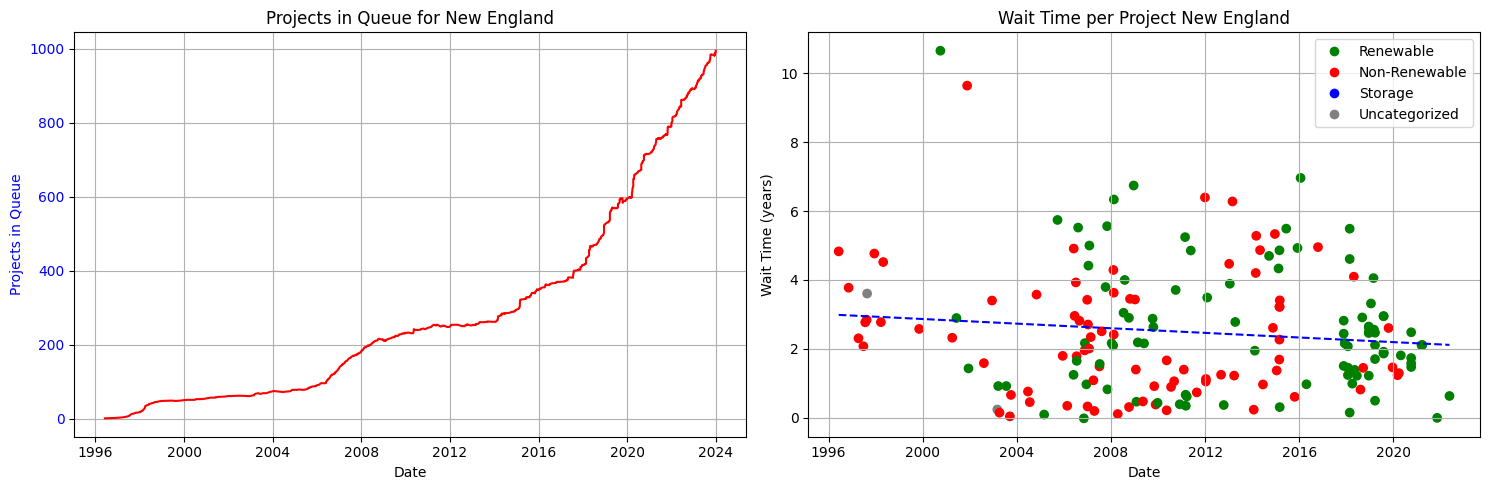

In [15]:
import matplotlib.pyplot as plt
# Define color mapping
def get_project_color(project_type):
    if project_type in renewable:
        return 'green'
    elif project_type in non_renewable:
        return 'red'
    elif project_type in storage:
        return 'blue'
    else:
        return 'gray'  # uncategorized

# Get colors for each point based on project type


iso_list = {
    "California": sorted_caiso,
    "ERCOT": sorted_ercot,
    # "PJM": sorted_pjm,
    "New England": sorted_iso_ne,
}
for name, iso in iso_list.items():
    completed_iso = iso[iso["on_date"].notna()]
    time_difference = calculate_difference(completed_iso)
    completed_dates = completed_iso["q_date"]
    queue = queue_length(iso)
    iso["queue"] = queue
    dates = iso["q_date"]

    # Create two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # First plot (Queue of Projects)
    ax1.plot(dates, queue, '-r', label="Projects in Queue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Projects in Queue", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title(f"Projects in Queue for {name}")
    ax1.grid()
    colors = completed_iso["type1"].apply(get_project_color)

# Scatter plot with color coding
    ax2.scatter(completed_dates, time_difference, c=colors, label="Wait Time per Project")

    # Optionally add a legend for color meaning (manually)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Renewable', markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Non-Renewable', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Storage', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Uncategorized', markerfacecolor='gray', markersize=8),
    ]
    ax2.legend(handles=legend_elements)
    # Second plot (Wait Time per Project with Trend Line)
    # ax2.scatter(completed_dates, time_difference, color='y', label="Wait Time per Project")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Wait Time (years)")
    ax2.tick_params(axis='y',)

    # Convert dates to numerical format for the trend line
    completed_dates_num = completed_dates.map(pd.Timestamp.toordinal)  # Convert dates to numbers
    coeffs = np.polyfit(completed_dates_num, time_difference, 1)  # Linear fit (degree=1)
    best_fit_line = np.polyval(coeffs, completed_dates_num)  # Compute best-fit values

    # Plot the best-fit line
    ax2.plot(completed_dates, best_fit_line, '--b', label="Trend Line")
    ax2.set_title(f"Wait Time per Project {name}")
    ax2.grid()

    # Improve layout and show
    fig.tight_layout()
    plt.show()

### Linear Regression for Deployed  Power Plants

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def linear_regression(iso, queue_func=None,randomness=False):

    X_train, X_test, y_train, y_test = data_split(iso, queue_func,randomness=randomness)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = linear_regression(iso,queue_func=queue_by_category_and_capacity,randomness=False)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

Total Completed Projects: 137
Total Withdrawn Projects: 0
R^2 Performance on seen data for Caiso :0.37465651301737435 

R^2 Performance on unseen data for Caiso :0.13242829323471061 

Total Completed Projects: 191
Total Withdrawn Projects: 0
R^2 Performance on seen data for Ercot :0.34903234429484986 

R^2 Performance on unseen data for Ercot :0.2034454830508463 

Total Completed Projects: 178
Total Withdrawn Projects: 0
R^2 Performance on seen data for NE :0.028647637679941607 

R^2 Performance on unseen data for NE :-0.10295608733907624 



In [17]:
from sklearn.ensemble import RandomForestRegressor


def random_forests(iso,queue_func=None,randomness = False):

    X_train, X_test, y_train, y_test = data_split(iso, queue_func,randomness=randomness)
    regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = random_forests(iso,queue_func=queue_by_category_and_capacity,randomness=False)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

Total Completed Projects: 137
Total Withdrawn Projects: 0
R^2 Performance on seen data for Caiso :0.8013703570555271 

R^2 Performance on unseen data for Caiso :-0.03509316301197263 

Total Completed Projects: 191
Total Withdrawn Projects: 0
R^2 Performance on seen data for Ercot :0.8356314981022279 

R^2 Performance on unseen data for Ercot :0.017097265770213532 

Total Completed Projects: 178
Total Withdrawn Projects: 0
R^2 Performance on seen data for NE :0.8080117767777659 

R^2 Performance on unseen data for NE :-0.07727440736049163 



include queue times, in the previous 4 or 5 projects

In [18]:
from sklearn.tree import DecisionTreeRegressor


def decision_tree(iso,queue_func=None,randomness=False):
    """Train and evaluate a Decision Tree Regressor on the given dataset."""

    X_train, X_test, y_train, y_test = data_split(iso, queue_func=queue_func,randomness=randomness)

    regressor = DecisionTreeRegressor()

    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)

    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = decision_tree(iso,queue_func=None,randomness=False)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

Total Completed Projects: 137
Total Withdrawn Projects: 0
R^2 Performance on seen data for Caiso :0.991622704381615 

R^2 Performance on unseen data for Caiso :-1.1350914795044864 

Total Completed Projects: 191
Total Withdrawn Projects: 0
R^2 Performance on seen data for Ercot :1.0 

R^2 Performance on unseen data for Ercot :-0.19142218340112782 

Total Completed Projects: 178
Total Withdrawn Projects: 0
R^2 Performance on seen data for NE :0.9745472266927717 

R^2 Performance on unseen data for NE :-0.6741291675926313 



In [19]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

def xgboost_cv(iso, queue_func=None, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, queue_func=queue_func, randomness=randomness)

    # Convert data to DMatrix format (XGBoost optimized data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define initial parameters
    params = {
        "max_depth": 5,
        "learning_rate": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "reg:squarederror",
        "seed": 42
    }

    # Perform cross-validation to determine optimal n_estimators
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=300,   # Max rounds
        nfold=5,               # 5-fold cross-validation
        metrics="rmse",        # Metric to evaluate
        early_stopping_rounds=10, # Stop if no improvement in 10 rounds
        verbose_eval=False
    )

    best_n_estimators = len(cv_results)  # Optimal number of boosting rounds

    # Train final model with optimal n_estimators
    best_xgb_model = XGBRegressor(n_estimators=best_n_estimators, **params)
    best_xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = best_xgb_model.predict(X_test)
    y_pred_train = best_xgb_model.predict(X_train)

    # Evaluate model performance
    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen

# Run the model for different datasets
for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = xgboost_cv(iso, queue_func=queue_by_category_and_capacity, randomness=True)
    print(f"R^2 Performance on seen data for {name}: {seen:.4f}")
    print(f"R^2 Performance on unseen data for {name}: {unseen:.4f}\n")

Total Completed Projects: 137
Total Withdrawn Projects: 0
R^2 Performance on seen data for Caiso: 0.7959
R^2 Performance on unseen data for Caiso: 0.3242

Total Completed Projects: 191
Total Withdrawn Projects: 0
R^2 Performance on seen data for Ercot: 0.5924
R^2 Performance on unseen data for Ercot: 0.2736

Total Completed Projects: 178
Total Withdrawn Projects: 0
R^2 Performance on seen data for NE: 0.4537
R^2 Performance on unseen data for NE: -0.0896



In [20]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def autoregression(iso, lag, extra_features=None):
    # Drop rows with missing on_date
    iso = iso[iso["on_date"].notna()]

    # Calculate time_difference (assumes function is defined elsewhere)
    iso["time_difference"] = calculate_difference(iso)

    # Drop rows with missing time_difference
    iso = iso.dropna(subset=['time_difference'])

    # Extract target series
    y = iso["time_difference"].to_numpy()

    # Handle exogenous features if provided
    if extra_features is None:
        exog = None
    else:
        exog = extra_features.to_numpy()

    # Train/test split
    train_size = int(len(y) * 0.8)
    train_y, test_y = y[:train_size], y[train_size:]

    if exog is not None:
        train_exog, test_exog = exog[:train_size], exog[train_size:]
    else:
        train_exog = test_exog = None

    # Fit the model
    model = AutoReg(train_y, lags=lag, exog=train_exog)
    model_fit = model.fit()

    # Predict
    predictions = model_fit.predict(start=train_size, end=len(y)-1, exog_oos=test_exog)

    return test_y, predictions, train_size, y


R² score for predicting time_difference: -0.0305


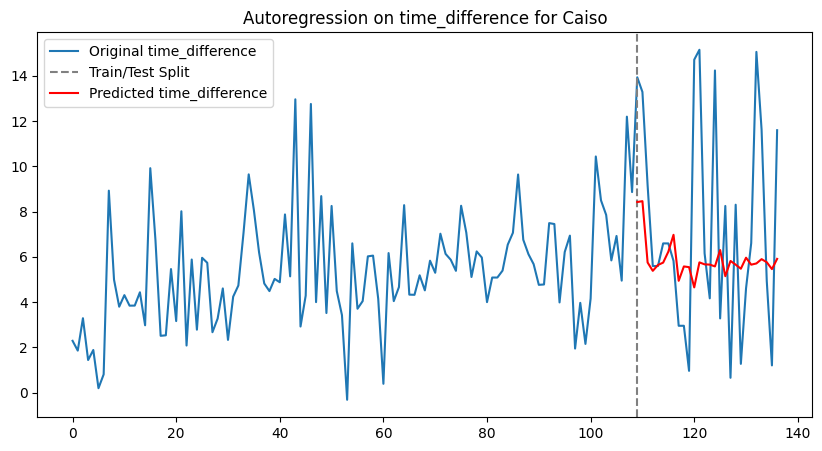

R² score for predicting time_difference: -0.3179


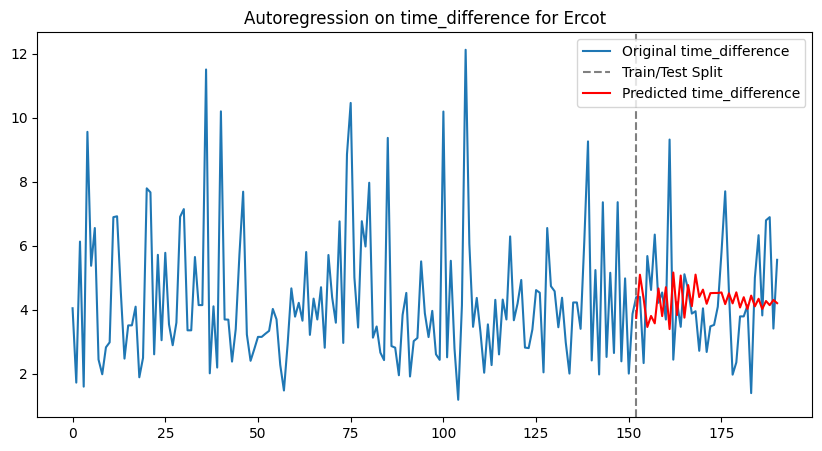

R² score for predicting time_difference: -0.0709


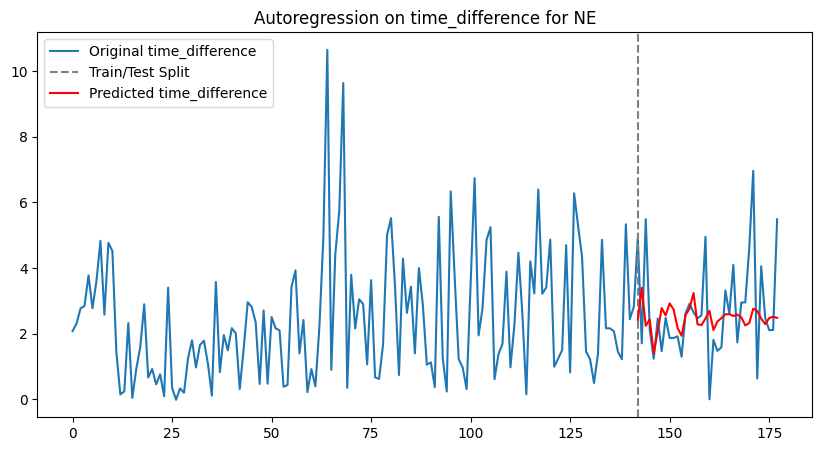

In [29]:
for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    # extra_features = queue_by_category(iso)
    iso = iso.sort_values(by="on_date", ascending = True)
    extra_features = None
    test, predictions, train_size, data  = autoregression(iso,20,extra_features=extra_features)
    r2 = r2_score(test, predictions)
    print(f"R² score for predicting time_difference: {r2:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Original time_difference')
    plt.axvline(x=train_size, color='gray', linestyle='--', label='Train/Test Split')
    plt.plot(range(train_size, len(data)), predictions, label='Predicted time_difference', color='red')
    plt.legend()
    plt.title(f"Autoregression on time_difference for {name}")
    plt.show()


In [22]:
from pmdarima import auto_arima


def moving_average(iso, lag, extra_features=None):
    # Drop rows with missing on_date
    iso = iso[iso["on_date"].notna()]

    # Calculate time_difference (assumes function is defined elsewhere)
    iso["time_difference"] = calculate_difference(iso)

    # Drop rows with missing time_difference
    iso = iso.dropna(subset=['time_difference'])

    # Extract target series
    y = iso["time_difference"].to_numpy()

    # # Handle exogenous features if provided
    # if extra_features is None:
    #     exog = None
    # else:
    #     exog = extra_features.to_numpy()

    # Train/test split
    train_size = int(len(y) * 0.8)
    train_y, test_y = y[:train_size], y[train_size:]

    # if exog is not None:
    #     train_exog, test_exog = exog[:train_size], exog[train_size:]
    # else:
    #     train_exog = test_exog = None

    # Fit the model
    model = auto_arima(train_y, seasonal=False, trace=True, error_action="ignore",suppress_warnings=True) #lags=lag) #exog=train_exog)
    n_periods = 10
    forecast = model.predict(n_periods=n_periods)
    r2 = r2_score(test_y, forecast)
    print(f"R² score for predicting time_difference: {r2:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Original time_difference')
    plt.axvline(x=train_size, color='gray', linestyle='--', label='Train/Test Split')
    plt.plot(range(train_size, len(data)), forecast, label='Predicted time_difference', color='red')
    plt.legend()
    plt.title(f"Autoregression on time_difference for {name}")
    plt.show()
# model = auto_arima(data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
